# CAL studies

In [1]:
import ROOT as R
import numpy as np
import pandas as pd
import time
from tqdm import tqdm

In [2]:
def draw1Dhist(hist, opt="HIST"):
    c = R.TCanvas(f"c_{hist.GetName()}","")
    c.cd()
    c.SetLogy(0)
    hist.Draw(opt)
    return c

def drawProfile2D(hcalprof, zmin, zmax):
    c = R.TCanvas(f"c_{hcalprof.GetName()}","")
    c.cd()
    R.gStyle.SetPaintTextFormat("0.f")
    hcalprof.SetMinimum(zmin)
    hcalprof.SetMaximum(zmax)
    hcalprof.Draw("COLZ,TEXT")
    return c

In [43]:
''' 
Require events to have exactly one hit in each board
And to have CALcode values that are close to the average CALcode
'''
def filterEvents(event):
    if not len(event) == 4: return False
    if not len(event['board']) == len(np.unique(event['board'])): return False
    return True

In [44]:
df = pd.read_feather('datos/loop_0.feather')

In [45]:
df = df.groupby('evt').filter(filterEvents)

In [46]:
df

,evt,bcid,l1a_counter,ea,board,row,col,toa,tot,cal
25,7,2318,203,0,0,15,1,192,100,167
26,7,2318,203,0,1,14,1,196,112,172
27,7,2318,203,0,2,14,1,220,113,175
28,7,2318,203,0,3,14,2,201,161,215
43,12,3436,208,0,0,8,6,89,110,172
...,...,...,...,...,...,...,...,...,...,...
6569224,1784690,719,192,0,3,10,8,169,172,212
6569231,1784692,2477,194,0,0,3,9,210,103,172
6569232,1784692,2477,194,0,1,2,9,200,98,171
6569233,1784692,2477,194,0,2,2,9,218,115,174


In [47]:
def getPixelMaximum(cal, col, row):
    if len(cal) == 0: return 0
    h = R.TH1F(f"h{col}{row}", "", 1023, 0., 1024.) # CAL ranges between 0 and 1023
    h.FillN(len(cal), cal, np.ones(len(cal)))
    maxval = h.GetMaximumBin()
    f = R.TF1("f","gaus")
    f.SetParameter(1,maxval)
    h.Fit("f","q","goff",maxval-2,maxval+2);
    #print(maxval, f.GetParameter(1))
    return f.GetParameter(1)

In [48]:
R.gROOT.ProcessLine('.L ./tdrstyle.C')
R.gROOT.SetBatch(1)
R.setTDRStyle()

In [49]:
h_acal = []
h_cal_time = []
for i in range(4):
    # Compute average cal
    h_acal_temp = R.TH2F(f"h_cal_B{i}", f"Board {i};col;row", 16, -0., 16., 16, -0., 16.) 
    for col in tqdm(range(16)):
        for row in range(16):
            dft = df[df['board']==i]
            dft = dft[dft['col']==col]
            dft = dft[dft['row']==row]
            cal = np.array(dft['cal'], dtype=float)
            acal = getPixelMaximum(cal, col, row)
            h_acal_temp.Fill(col, row, acal)
            
            event = np.array(dft['evt'], dtype=float)
            if len(event) == 0: 
                h_cal_time_temp = R.TH2F(f"h_cal_time_B{i}C{col}R{row}", f"B{i}C{col}R{row};Event;calCODE", 
                                     1, 0., 1., 5, int(acal)-2, int(acal)+3)
                h_cal_time.append(h_cal_time_temp)
            else:
                h_cal_time_temp = R.TH2F(f"h_cal_time_B{i}C{col}R{row}", f"B{i}C{col}R{row};Event;calCODE", 
                                     len(event), min(event), max(event)+1, 5, int(acal)-2, int(acal)+3)
                h_cal_time_temp.FillN(len(event), event, cal, np.ones(len(event)))
                h_cal_time.append(h_cal_time_temp)
    h_acal.append(h_acal_temp)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:05<00:00,  2.88it/s]


Warning in <TCanvas::Constructor>: Deleting canvas with same name: cprof


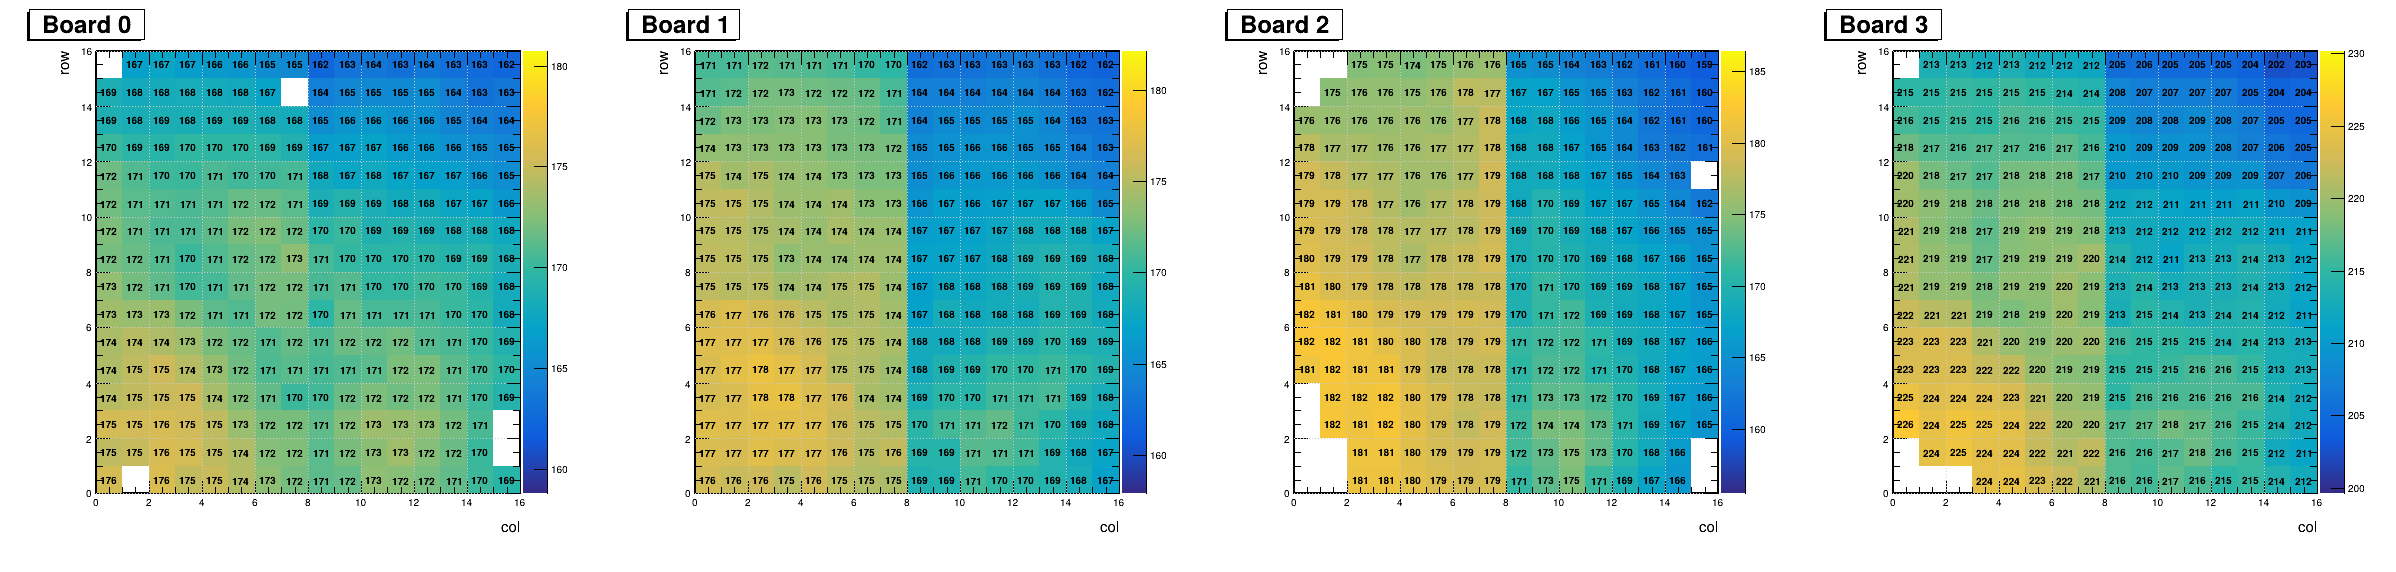

In [52]:
R.gStyle.SetPaintTextFormat("0.f")
cprof = R.TCanvas("cprof","",2400,600)
cprof.Divide(4,1)
for i in range(4):
    cprof.cd(i+1)
    h_acal[i].Draw("COLZ,TEXT")
    h_acal[i].SetMinimum(h_acal[i].GetBinContent(16,14)-5)
    h_acal[i].SetMaximum(h_acal[i].GetBinContent(3,2)+5)
cprof.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: cprof


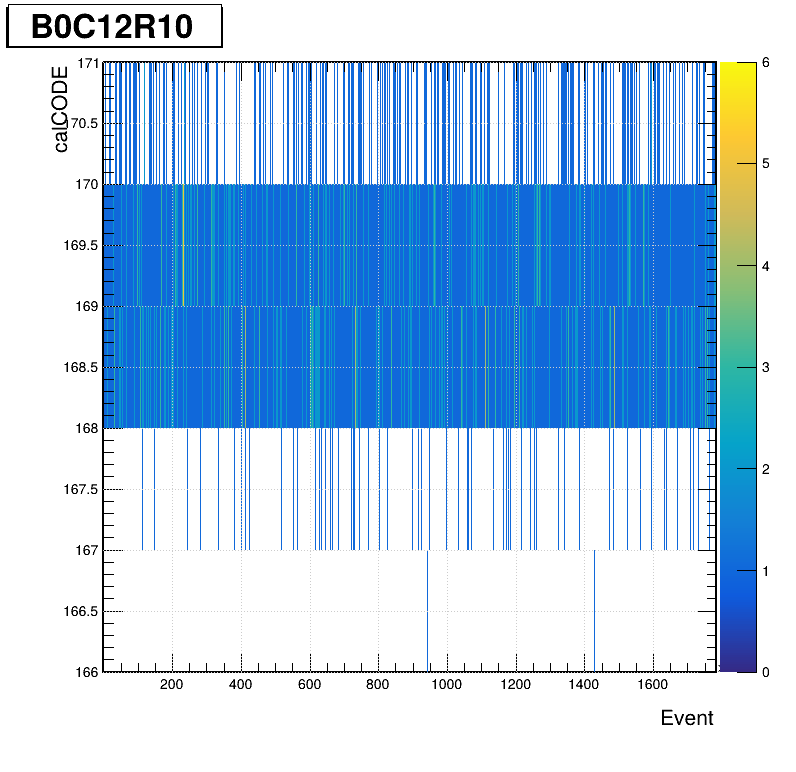

In [42]:
BOA = 3
ROW = 10
COL = 6
cprof = R.TCanvas("cprof","",800,800)
cprof.cd()
h_cal_time[32*BOA+16*COL+ROW].Draw("COLZ")
cprof.Draw()

In [56]:
df['acal'] = df.apply(lambda x: h_acal[x['board']].GetBinContent(int(x['col']),int(x['row'])), axis=1)

In [57]:
df

,evt,bcid,l1a_counter,ea,board,row,col,toa,tot,cal,acal
25,7,2318,203,0,0,15,1,192,100,167,168.518814
26,7,2318,203,0,1,14,1,196,112,172,172.065247
27,7,2318,203,0,2,14,1,220,113,175,175.963577
28,7,2318,203,0,3,14,2,201,161,215,215.217178
43,12,3436,208,0,0,8,6,89,110,172,171.390472
...,...,...,...,...,...,...,...,...,...,...,...
6569224,1784690,719,192,0,3,10,8,169,172,212,218.445831
6569231,1784692,2477,194,0,0,3,9,210,103,172,171.288269
6569232,1784692,2477,194,0,1,2,9,200,98,171,169.480026
6569233,1784692,2477,194,0,2,2,9,218,115,174,171.867508


In [59]:
df = df[abs(df['acal']-df['cal'])<2]
df = df.groupby('evt').filter(filterEvents)

In [60]:
df

,evt,bcid,l1a_counter,ea,board,row,col,toa,tot,cal,acal
25,7,2318,203,0,0,15,1,192,100,167,168.518814
26,7,2318,203,0,1,14,1,196,112,172,172.065247
27,7,2318,203,0,2,14,1,220,113,175,175.963577
28,7,2318,203,0,3,14,2,201,161,215,215.217178
43,12,3436,208,0,0,8,6,89,110,172,171.390472
...,...,...,...,...,...,...,...,...,...,...,...
6569162,1784672,647,174,0,3,5,7,702,205,220,218.686188
6569189,1784680,151,182,0,0,8,5,213,114,172,170.520615
6569190,1784680,151,182,0,1,8,5,211,111,174,174.346054
6569191,1784680,151,182,0,2,7,5,246,127,179,178.782806


# Pairwise TOA without TWC

# Apply Time Walk Correction

### 1. Convert to ps

In [105]:
tracks_df = df
tracks_df['toa_ps'] = 1000*(12.5-tracks_df['toa']*3.125/tracks_df['acal'])
tracks_df['tot_ps'] = 1000*((2.*tracks_df['tot']-np.floor(tracks_df['tot']/32.))*3.125/tracks_df['acal'])

In [106]:
# Get pixel with highest statistics
Nevents = []
for col in range(16):
    for row in range(16):
        N = len(tracks_df[(tracks_df['row']==row)*(tracks_df['col']==col)])
        print(f"B 3 | C {col} | R {row} ---- {N}")
        Nevents.append(N)
print(max(Nevents))

B 3 | C 0 | R 0 ---- 0
B 3 | C 0 | R 1 ---- 0
B 3 | C 0 | R 2 ---- 0
B 3 | C 0 | R 3 ---- 0
B 3 | C 0 | R 4 ---- 0
B 3 | C 0 | R 5 ---- 1
B 3 | C 0 | R 6 ---- 0
B 3 | C 0 | R 7 ---- 0
B 3 | C 0 | R 8 ---- 0
B 3 | C 0 | R 9 ---- 0
B 3 | C 0 | R 10 ---- 0
B 3 | C 0 | R 11 ---- 0
B 3 | C 0 | R 12 ---- 0
B 3 | C 0 | R 13 ---- 0
B 3 | C 0 | R 14 ---- 0
B 3 | C 0 | R 15 ---- 0
B 3 | C 1 | R 0 ---- 0
B 3 | C 1 | R 1 ---- 11
B 3 | C 1 | R 2 ---- 12
B 3 | C 1 | R 3 ---- 23
B 3 | C 1 | R 4 ---- 66
B 3 | C 1 | R 5 ---- 3567
B 3 | C 1 | R 6 ---- 1573
B 3 | C 1 | R 7 ---- 2454
B 3 | C 1 | R 8 ---- 4505
B 3 | C 1 | R 9 ---- 5171
B 3 | C 1 | R 10 ---- 4633
B 3 | C 1 | R 11 ---- 2518
B 3 | C 1 | R 12 ---- 1896
B 3 | C 1 | R 13 ---- 2334
B 3 | C 1 | R 14 ---- 1485
B 3 | C 1 | R 15 ---- 254
B 3 | C 2 | R 0 ---- 0
B 3 | C 2 | R 1 ---- 3
B 3 | C 2 | R 2 ---- 44
B 3 | C 2 | R 3 ---- 3090
B 3 | C 2 | R 4 ---- 1633
B 3 | C 2 | R 5 ---- 3123
B 3 | C 2 | R 6 ---- 2561
B 3 | C 2 | R 7 ---- 2865
B 3 | C 2 | R 8 

In [107]:
BOA = 3
COL = 11
ROW = 9
tracks_df = tracks_df.groupby('evt').filter(lambda x: len(x)==4 and list(x['col'])[BOA]==COL and list(x['row'])[BOA]==ROW)

In [108]:
tracks_df

,evt,bcid,l1a_counter,ea,board,row,col,toa,tot,cal,acal,toa_ps,tot_ps
9888,2686,1627,66,0,0,10,11,59,110,167,168.887985,11408.300080,4015.235300
9889,2686,1627,66,0,1,9,11,66,108,168,167.246445,11266.789929,3979.905230
9890,2686,1627,66,0,2,9,10,80,112,169,170.252243,11031.590565,4056.481064
9891,2686,1627,66,0,3,9,11,33,151,212,211.376358,12012.126139,4405.648809
11374,3107,2323,231,0,0,10,11,631,106,168,168.887985,824.361870,3867.208192
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6565835,1783790,1573,60,0,3,9,11,220,164,212,211.376358,9247.507591,4775.250219
6569035,1784642,1461,144,0,0,10,11,368,115,168,168.887985,5690.753040,4200.269185
6569036,1784642,1461,144,0,1,9,10,371,113,168,167.085388,5561.182593,4170.771649
6569037,1784642,1461,144,0,2,9,10,386,110,169,170.252243,5414.924476,3983.060592


In [109]:
def plotMulti1D(c, hists, names, colors):
    c = R.TCanvas(f"{c}","")
    c.cd()
    l = R.TLegend(0.6,0.2,0.8,0.4)
    for i,h in enumerate(hists):
        if i==0: h.Draw("HIST")
        else: h.Draw("HIST,SAME")
        h.SetLineColor(colors[i])
        h.SetLineWidth(2)
        l.AddEntry(h, names[i],"L")
    return c, l

Warning in <TCanvas::Constructor>: Deleting canvas with same name: ctoa
Warning in <TCanvas::Constructor>: Deleting canvas with same name: ctot


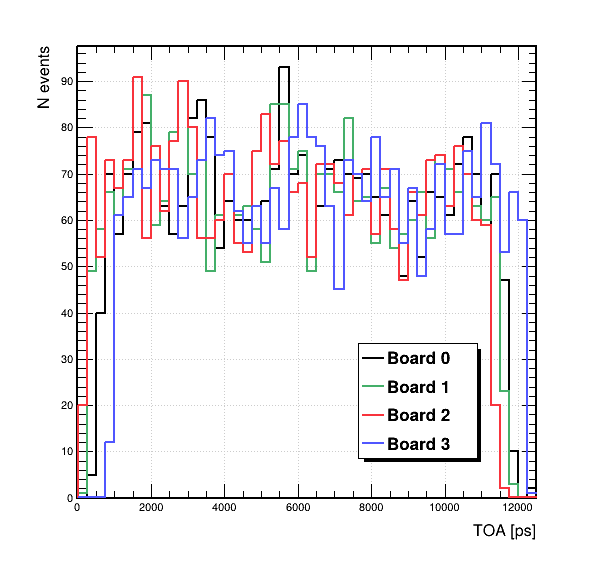

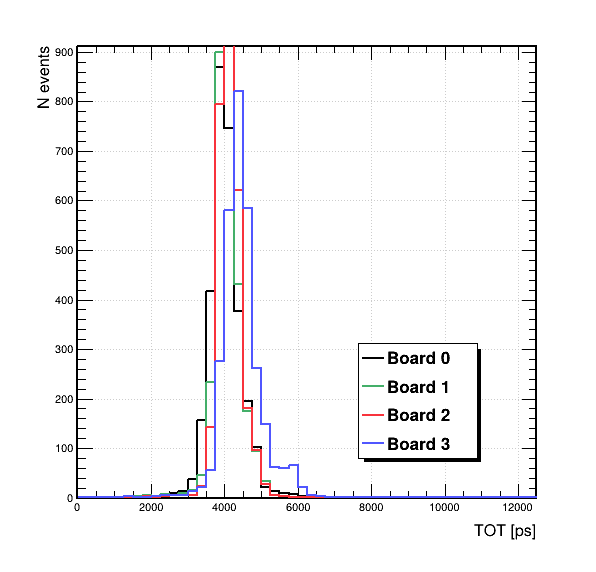

In [110]:
NBINS = 50

colors = [R.kBlack,
          R.TColor.GetColor("#44AF69"),
          R.TColor.GetColor("#F8333C"),
          R.TColor.GetColor("#5056FF")]
leg = []
toa, htoa = [], []
for i in range(4):
    toa.append(np.array(tracks_df[tracks_df['board']==i]['toa_ps'], dtype=float))
    htoa.append(R.TH1F(f"htoa{i}",";TOA [ps];N events", NBINS, 0., 12500.))
    htoa[i].FillN(len(toa[i]), toa[i], np.ones(len(toa[i])))
    leg.append(f"Board {i}")
ctoa, ltoa = plotMulti1D("ctoa", htoa, leg, colors)
ctoa.cd()
ltoa.Draw()

leg = []
tot, htot = [], []
for i in range(4):
    tot.append(np.array(tracks_df[tracks_df['board']==i]['tot_ps'], dtype=float))
    htot.append(R.TH1F(f"htot{i}",";TOT [ps];N events", NBINS, 0., 12500.))
    htot[i].FillN(len(tot[i]), tot[i], np.ones(len(tot[i])))
    leg.append(f"Board {i}")
ctot, ltot = plotMulti1D("ctot", htot, leg, colors)
ctot.cd()
ltot.Draw()

ctoa.Draw()
ctot.Draw()

In [111]:
# Compute delta ToA
'''cuttoa = []
cuttoa.append( (tracks_df['board']==1).values)# * (tracks_df['tot_ps']>2300.).values * (tracks_df['tot_ps']<4700.).values )
print(cuttoa1)
print(np.array(tracks_df[cuttoa1]['toa_ps']))
cuttoa.append( (tracks_df['board']==2).values)# * (tracks_df['tot_ps']>3400.).values * (tracks_df['tot_ps']<4700.).values )
cuttoa.append( (tracks_df['board']==3).values)# * (tracks_df['tot_ps']>2400.).values * (tracks_df['tot_ps']<5800.).values )'''

print('- Computing deltaTOA...')
deltaTOA = []
for i in range(1,4):
    j = (i) % 3 + 1
    k = (i+1) % 3 + 1
    print(i,j,k)
    toai = np.array(tracks_df[tracks_df['board']==i]['toa_ps'])
    toaj = np.array(tracks_df[tracks_df['board']==j]['toa_ps'])
    toak = np.array(tracks_df[tracks_df['board']==k]['toa_ps'])
    deltaTOA.append((toaj+toak)/2-toai)

tot1 = np.array(tracks_df[tracks_df['board']==1]['tot_ps'])
tot2 = np.array(tracks_df[tracks_df['board']==2]['tot_ps'])
tot3 = np.array(tracks_df[tracks_df['board']==3]['tot_ps'])
toa1 = np.array(tracks_df[tracks_df['board']==1]['toa_ps'])
toa2 = np.array(tracks_df[tracks_df['board']==2]['toa_ps'])
toa3 = np.array(tracks_df[tracks_df['board']==3]['toa_ps'])

tot_all = np.concatenate((tot1,tot2,tot3))
deltaTOA_all = np.concatenate(deltaTOA)
print(f'Max tot = {np.max(abs(tot_all))}')
print(f'Max deltaTOA = {np.max(abs(deltaTOA_all))}')

- Computing deltaTOA...
1 2 3
2 3 1
3 1 2
Max tot = 10200.998919998692
Max deltaTOA = 10039.718123536884


In [99]:
cuttoa = []
cuttoa.append( (tot1>2300.) * (tot1<4700.) )
print(cuttoa[0])
cuttoa.append( (tot2>3400.) * (tot2<4700.) )
cuttoa.append( (tot3>2400.) * (tot3<5800.) )

deltaTOA_uppercut = []
tot = [tot1,tot2,tot3]
tot_uppercut = []
toa = [toa1,toa2,toa3]
toa_uppercut = []
for i in range(3):
    deltaTOA_uppercut.append(deltaTOA[i][(deltaTOA[i]<2000)])
    tot_uppercut.append(tot[i][(deltaTOA[i]<2000)])
    toa_uppercut.append(toa[i][(deltaTOA[i]<2000)])
    print(np.shape(deltaTOA[i]),np.shape(deltaTOA_uppercut[i]),np.shape(tot_uppercut[i]))

[ True False  True ...  True  True  True]
(3009,) (3008,) (3008,)
(3009,) (3008,) (3008,)
(3009,) (3009,) (3009,)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3009/3009 [00:00<00:00, 1689512.82it/s]
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Warning in <TROOT::Append>: Replacing existing TH1: h1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h2 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h3 (Potential memory leak).


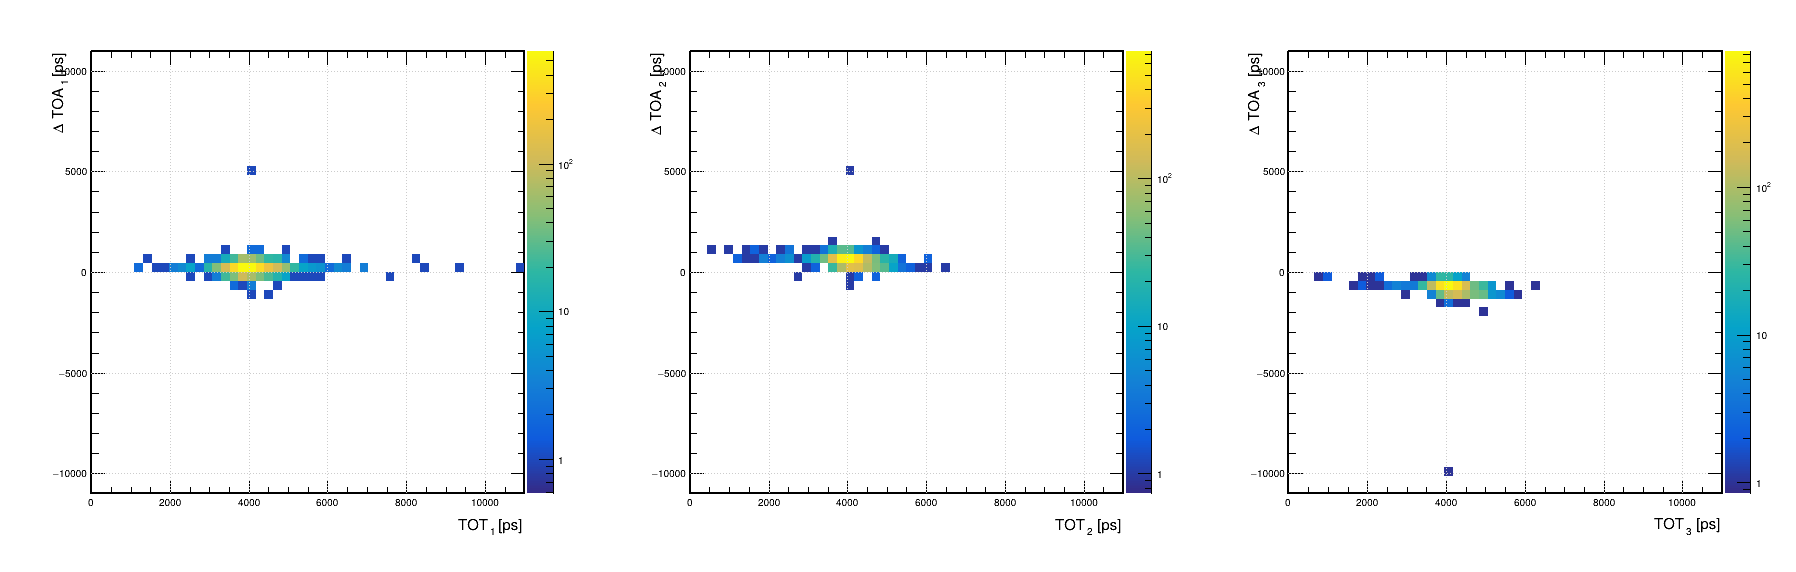

In [115]:
c1 = R.TCanvas("c1", "#Delta TOA", 1800, 600)  # Width = 1200, Height = 400
c1.Divide(3, 1)

h1 = R.TH2F("h1",";TOT_{1} [ps];#Delta TOA_{1} [ps]",50,0,11000.,50,-11000,11000)
h2 = R.TH2F("h2",";TOT_{2} [ps];#Delta TOA_{2} [ps]",50,0,11000.,50,-11000,11000)
h3 = R.TH2F("h3",";TOT_{3} [ps];#Delta TOA_{3} [ps]",50,0,11000.,50,-11000,11000)
h = [h1,h2,h3]
for j in range(3):
    for i in tqdm(range(len(tot_uppercut[j]))):
        h[j].Fill(tot[j][i],deltaTOA[j][i])
c1.GetPad(1).SetLogz()
c1.GetPad(2).SetLogz()
c1.GetPad(3).SetLogz()
c1.cd(1)
h1.Draw("COLZ")
c1.cd(2)
h2.Draw("COLZ")
c1.cd(3)
h3.Draw("COLZ")
c1.Draw()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3009/3009 [00:00<00:00, 594641.01it/s]
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Warning in <TROOT::Append>: Replacing existing TH1: h1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h2 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h3 (Potential memory leak).


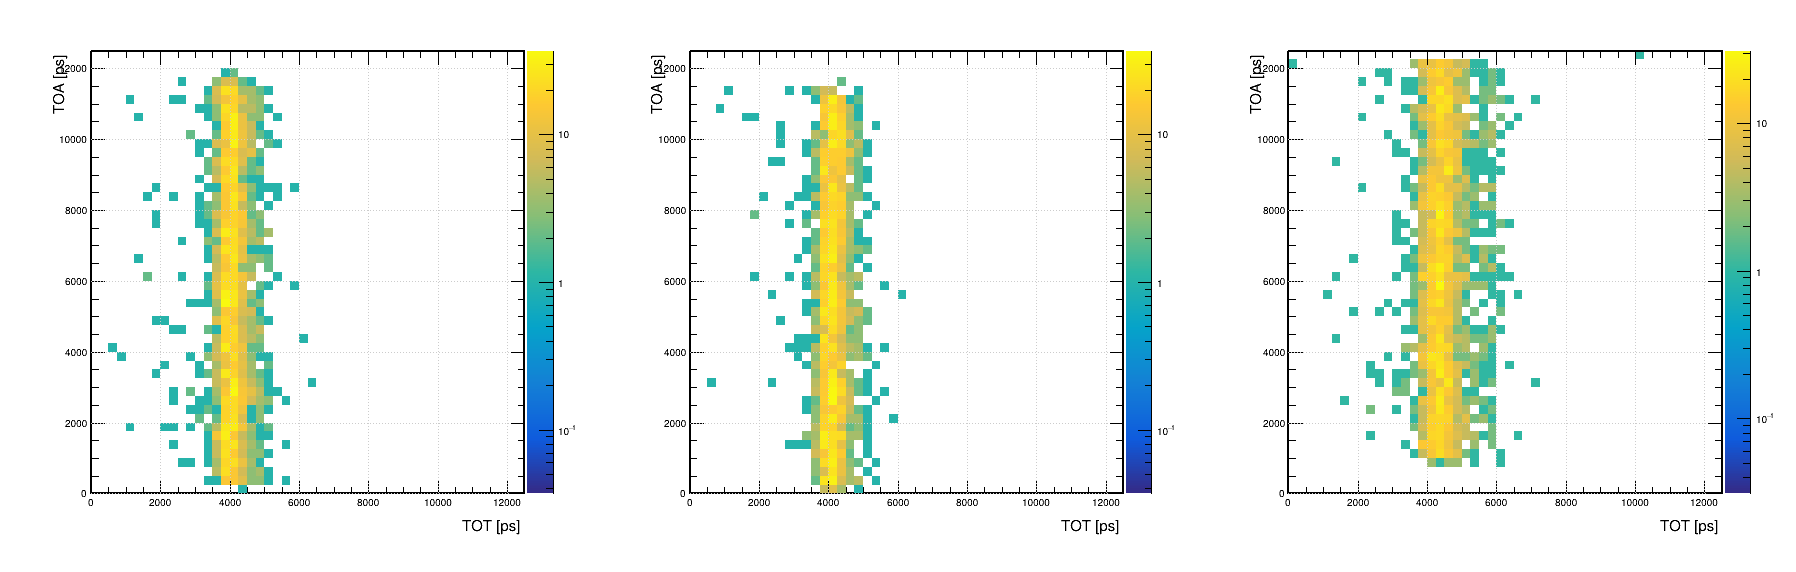

In [101]:
c1 = R.TCanvas("c1", "#Delta TOA", 1800, 600)  # Width = 1200, Height = 400
c1.Divide(3, 1)

h1 = R.TH2F("h1",";TOT [ps];TOA [ps]",50,0,12500.,50,0.,12500)
h2 = R.TH2F("h2",";TOT [ps];TOA [ps]",50,0,12500.,50,0.,12500)
h3 = R.TH2F("h3",";TOT [ps];TOA [ps]",50,0,12500.,50,0.,12500)
h = [h1,h2,h3]
for j in range(3):
    for i in tqdm(range(len(tot_uppercut[j]))):
        h[j].Fill(tot_uppercut[j][i],toa_uppercut[j][i])
c1.GetPad(1).SetLogz()
c1.GetPad(2).SetLogz()
c1.GetPad(3).SetLogz()
c1.cd(1)
h1.Draw("COLZ")
c1.cd(2)
h2.Draw("COLZ")
c1.cd(3)
h3.Draw("COLZ")
c1.Draw()

163.3316576560992 127.81000502995896 158.25108530786645
sigma1 = 133.01360646198694
sigma2 = 94.7871873655129
sigma3 = 85.73672781890667
****************************************
Minimizer is Minuit2 / Migrad
Chi2                      =      3796.35
NDf                       =           95
Edm                       =  9.48564e-06
NCalls                    =           73
Constant                  =      101.896   +/-   1.80363     
Mean                      =      211.196   +/-   3.24699     
Sigma                     =      163.332   +/-   3.54212      	 (limited)
****************************************
Minimizer is Minuit2 / Migrad
Chi2                      =      4667.45
NDf                       =           94
Edm                       =  1.40209e-08
NCalls                    =           81
Constant                  =       114.12   +/-   2.15929     
Mean                      =     -870.772   +/-   2.68595     
Sigma                     =       127.81   +/-   2.9937       	 (limite

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Warning in <TROOT::Append>: Replacing existing TH1: h1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h2 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h3 (Potential memory leak).


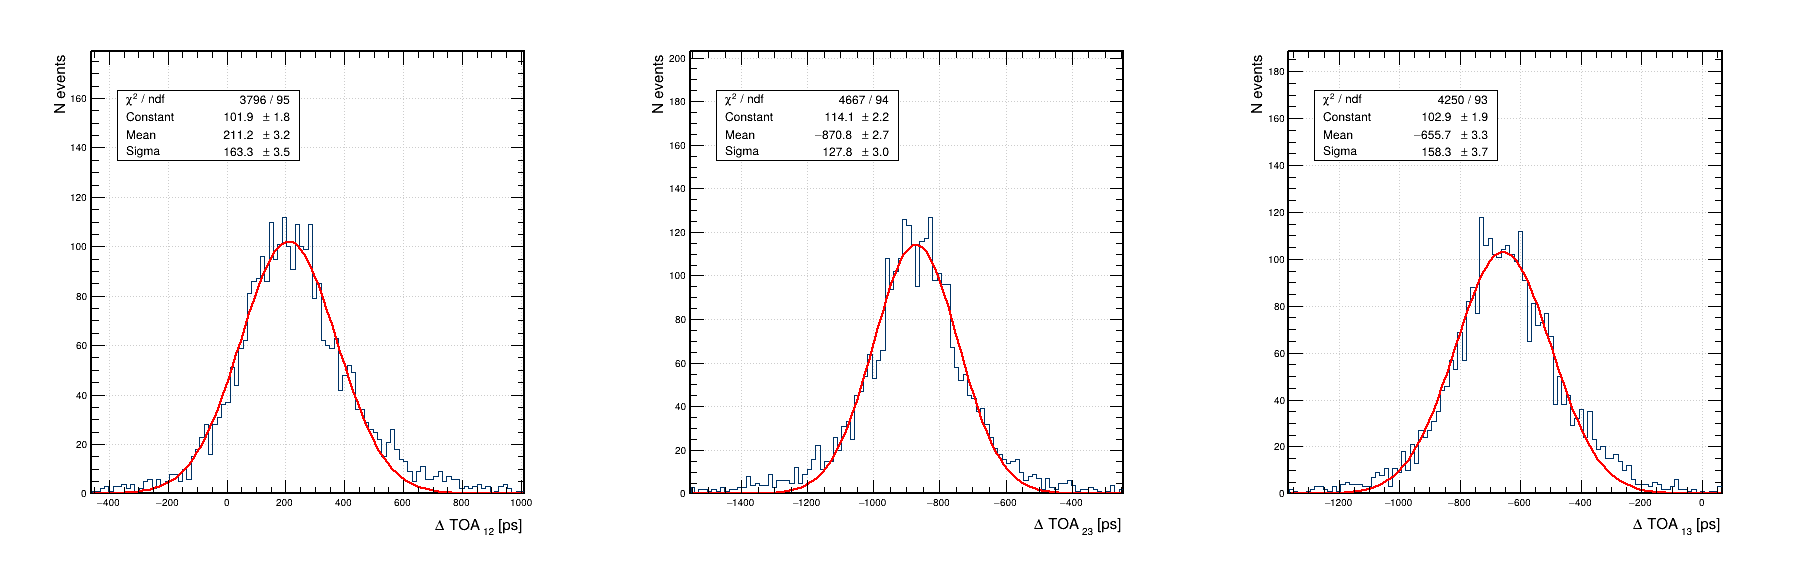

In [102]:
colorp = [R.TColor.GetColor("#44AF69"),
          R.TColor.GetColor("#F8333C"),
          R.TColor.GetColor("#2E3860"),
          R.kAzure+3]

toa1 = np.array(tracks_df[tracks_df['board']==1]['toa_ps'])
toa2 = np.array(tracks_df[tracks_df['board']==2]['toa_ps'])
toa3 = np.array(tracks_df[tracks_df['board']==3]['toa_ps'])

fg1 = R.TF1("fg1","gaus")
fg2 = R.TF1("fg2","gaus")
fg3 = R.TF1("fg3","gaus")
c1 = R.TCanvas("c1", "'#Delta TOA", 1800, 600)  # Width = 1200, Height = 400
c1.Divide(3, 1)

appr_mean = np.array([275.99, -900, -650])
appr_sigma = np.array([184, 164, 179])
lowlim = appr_mean-4*appr_sigma
highlim = appr_mean+4*appr_sigma

l = R.TLatex()
l.SetTextSize(0.03)
l.SetTextAlign(12)
l.SetTextFont(42)

hists = []

h1 = R.TH1F("h1",";#Delta TOA_{12} [ps]; N events",100,lowlim[0],highlim[0])
h1.FillN(len(toa1-toa2), toa1-toa2, np.ones(len(toa1)))
hists.append(h1)

h2 = R.TH1F("h2",";#Delta TOA_{23} [ps]; N events",100,lowlim[1],highlim[1])
h2.FillN(len(toa2-toa3), toa2-toa3, np.ones(len(toa2)))
hists.append(h1)

h3 = R.TH1F("h3",";#Delta TOA_{13} [ps]; N events",100,lowlim[2],highlim[2])
h3.FillN(len(toa1-toa3), toa1-toa3, np.ones(len(toa3)))
hists.append(h1)

c1.cd(1)
h1.Fit("fg1","W","",lowlim[0],highlim[0])
h1.SetMaximum(h1.GetMaximum()*1.6)
h1.SetLineColor(colorp[3])
h1.Draw()
#l.DrawLatexNDC(0.17,0.8,f"#mu = {fg1.GetParameter(1):.1f}#pm {fg1.GetParError(1):.1f} ps")
#l.DrawLatexNDC(0.17,0.77,f"#sigma = {fg1.GetParameter(2):.1f}#pm {fg1.GetParError(2):.1f} ps")

c1.cd(2)
h2.Fit("fg2","W","",lowlim[1],highlim[1])
h2.SetMaximum(h2.GetMaximum()*1.6)
h2.SetLineColor(colorp[3])
h2.Draw()
#l.DrawLatexNDC(0.17,0.8,f"#mu = {fg2.GetParameter(1):.1f}#pm {fg2.GetParError(1):.1f} ps")
#l.DrawLatexNDC(0.17,0.77,f"#sigma = {fg2.GetParameter(2):.1f}#pm {fg2.GetParError(2):.1f} ps")

c1.cd(3)
h3.Fit("fg3","W","",lowlim[2],highlim[2])
h3.SetMaximum(h3.GetMaximum()*1.6)
h3.SetLineColor(colorp[3])
h3.Draw()
#l.DrawLatexNDC(0.17,0.8,f"#mu = {fg3.GetParameter(1):.1f}#pm {fg3.GetParError(1):.1f} ps")
#l.DrawLatexNDC(0.17,0.77,f"#sigma = {fg3.GetParameter(2):.1f}#pm {fg3.GetParError(2):.1f} ps")

c1.Draw()

sigma12 = fg1.GetParameter(2)
sigma23 = fg2.GetParameter(2)
sigma13 = fg3.GetParameter(2)
print(sigma12, sigma23, sigma13)
sigma1 = np.sqrt((sigma12**2+sigma13**2-sigma23**2)/2)
sigma2 = np.sqrt((sigma12**2+sigma23**2-sigma13**2)/2)
sigma3 = np.sqrt((sigma23**2+sigma13**2-sigma12**2)/2)
print(f"sigma1 = {sigma1}")
print(f"sigma2 = {sigma2}")
print(f"sigma3 = {sigma3}")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3009/3009 [00:00<00:00, 691050.80it/s]

****************************************
Minimizer is Linear / Migrad
Chi2                      =      92747.7
NDf                       =           16
p0                        =     -1167.39   +/-   481.745     
p1                        =     0.387697   +/-   0.281688    
p2                        = -1.18571e-05   +/-   4.00082e-05 
****************************************
Minimizer is Linear / Migrad
Chi2                      =       7251.9
NDf                       =           17
p0                        =      1170.42   +/-   602.069     
p1                        =    -0.606156   +/-   0.2991      
p2                        =  0.000109871   +/-   3.68945e-05 
****************************************
Minimizer is Linear / Migrad
Chi2                      =      12197.9
NDf                       =           17
p0                        =     -1822.48   +/-   113.822     
p1                        =     0.281968   +/-   0.0576862   
p2                        =  -1.0068e-05   +/-  


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Warning in <TROOT::Append>: Replacing existing TH1: h1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h2 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h3 (Potential memory leak).


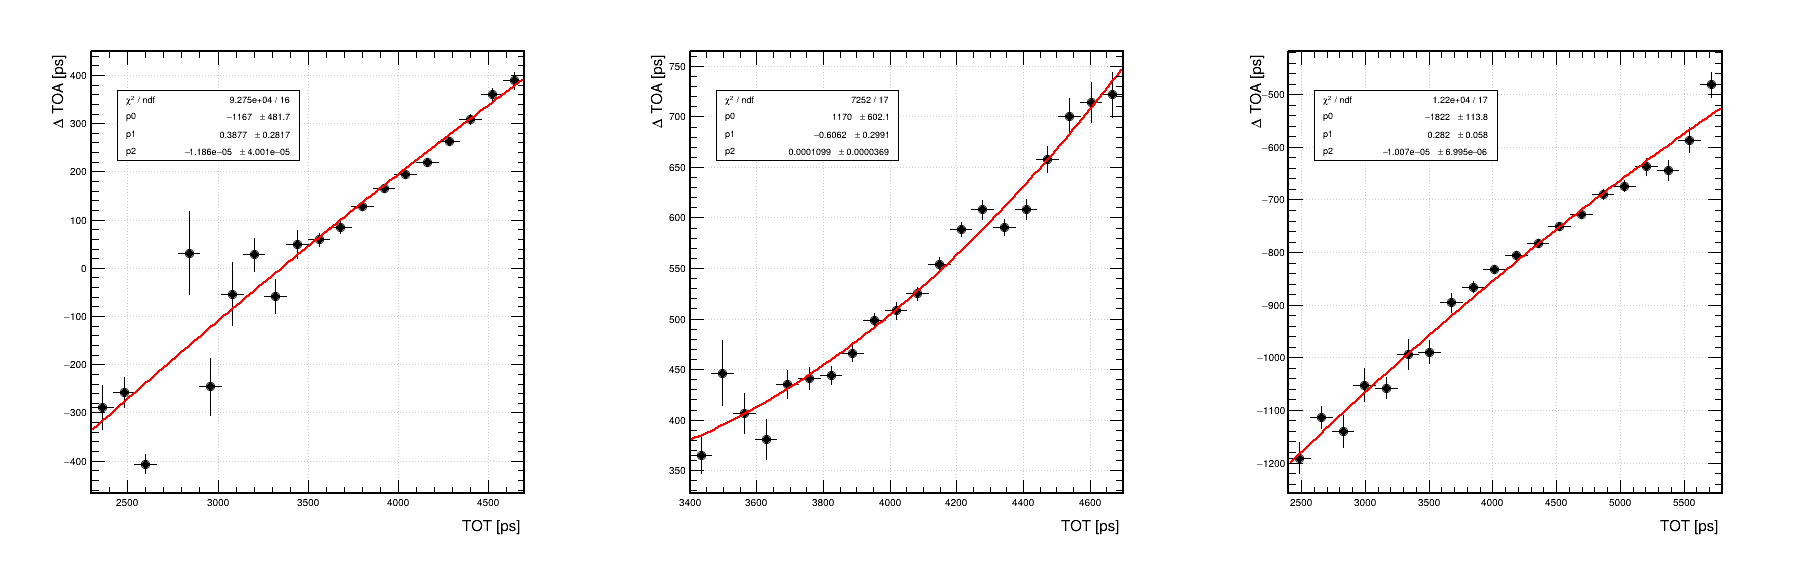

In [103]:
R.gStyle.SetStatX(0.5)
R.gStyle.SetStatY(0.85)
c1 = R.TCanvas("c1", "", 1800, 600)  # Width = 1200, Height = 400
c1.Divide(3, 1)

f1 = R.TF1("f1","pol2",0.,8000.)
f2 = R.TF1("f2","pol2",0.,8000.)
f3 = R.TF1("f3","pol2",0.,8000.)
h1 = R.TProfile("h1",";TOT [ps];#Delta TOA [ps]",20,2300.,4700.)
h2 = R.TProfile("h2",";TOT [ps];#Delta TOA [ps]",20,3400.,4700.)
h3 = R.TProfile("h3",";TOT [ps];#Delta TOA [ps]",20,2400.,5800.)
h = [h1,h2,h3]
for j in range(3):
    for i in tqdm(range(len(tot_uppercut[j]))):
        h[j].Fill(tot_uppercut[j][i],deltaTOA_uppercut[j][i])
c1.cd(1)
h1.Draw("COLZ")
h1.Fit("f1","W","",2300.,4700.)
c1.cd(2)
h2.Draw("COLZ")
h2.Fit("f2","W","",3400.,4700.)
c1.cd(3)
h3.Draw("COLZ")
h3.Fit("f3","W","",2400.,5800.)
c1.Draw()

111.9614196484955 79.0161261212845 101.3568006619266
sigma1 = 91.00827529107806 ps
sigma2 = 65.21390433220407 ps
sigma3 = 44.617203733143945 ps
****************************************
Minimizer is Minuit2 / Migrad
Chi2                      =      9425.81
NDf                       =           65
Edm                       =  7.52507e-06
NCalls                    =           61
Constant                  =      148.487   +/-   4.27415     
Mean                      =     -123.735   +/-   3.54149     
Sigma                     =      111.961   +/-   4.13243      	 (limited)
****************************************
Minimizer is Minuit2 / Migrad
Chi2                      =      3489.49
NDf                       =           59
Edm                       =   3.5113e-06
NCalls                    =           67
Constant                  =      189.163   +/-   2.95411     
Mean                      =      443.185   +/-   1.39062     
Sigma                     =      79.0161   +/-   1.4911       	 

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Warning in <TROOT::Append>: Replacing existing TH1: h1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h2 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h3 (Potential memory leak).


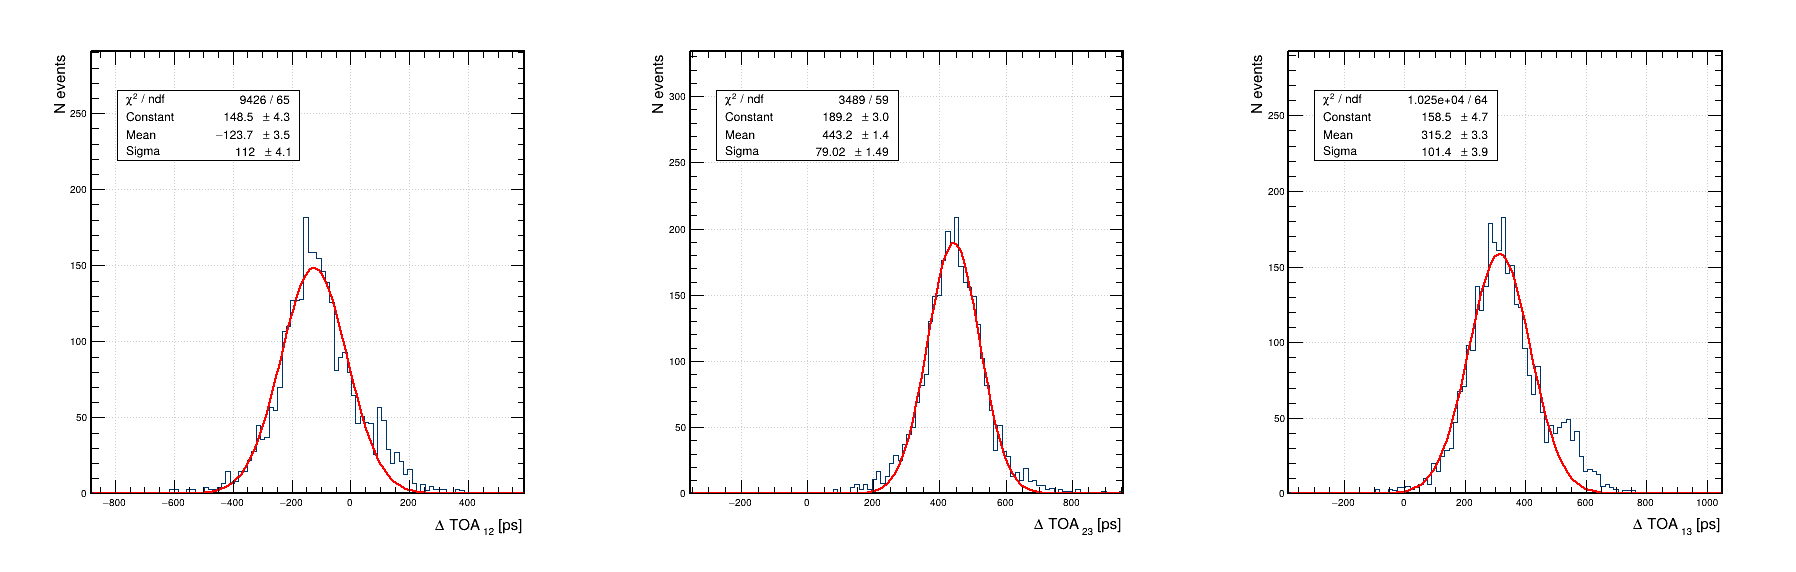

In [104]:
f1pars = [f1.GetParameter(0),f1.GetParameter(1),f1.GetParameter(2)]
f2pars = [f2.GetParameter(0),f2.GetParameter(1),f2.GetParameter(2)]
f3pars = [f3.GetParameter(0),f3.GetParameter(1),f3.GetParameter(2)]
ftot1 = f1pars[0] + f1pars[1]*tot1 + f1pars[2]*tot1*tot1
ftot2 = f2pars[0] + f2pars[1]*tot2 + f2pars[2]*tot2*tot2
ftot3 = f3pars[0] + f3pars[1]*tot3 + f3pars[2]*tot3*tot3
corrtoa1 = toa1 + ftot1
corrtoa2 = toa2 + ftot2
corrtoa3 = toa3 + ftot3

c1 = R.TCanvas("c1", "'#Delta TOA", 1800, 600)  # Width = 1200, Height = 400
c1.Divide(3, 1)

appr_mean = np.array([-145, 300, 333])
appr_sigma = np.array([184, 164, 179])
lowlim = appr_mean-4*appr_sigma
highlim = appr_mean+4*appr_sigma

l = R.TLatex()
l.SetTextSize(0.03)
l.SetTextAlign(12)
l.SetTextFont(42)

hists = []

h1 = R.TH1F("h1",";#Delta TOA_{12} [ps]; N events",100,lowlim[0],highlim[0])
h1.FillN(len(toa2-toa1), corrtoa1-corrtoa2, np.ones(len(toa1)))
hists.append(h1)

h2 = R.TH1F("h2",";#Delta TOA_{23} [ps]; N events",100,lowlim[1],highlim[1])
h2.FillN(len(toa3-toa2), corrtoa2-corrtoa3, np.ones(len(toa2)))
hists.append(h1)

h3 = R.TH1F("h3",";#Delta TOA_{13} [ps]; N events",100,lowlim[2],highlim[2])
h3.FillN(len(toa1-toa3), corrtoa1-corrtoa3, np.ones(len(toa3)))
hists.append(h1)

c1.cd(1)
h1.Fit("fg1","W","",lowlim[0],highlim[0])
h1.SetMaximum(h1.GetMaximum()*1.6)
h1.SetLineColor(colorp[3])
h1.Draw()
#l.DrawLatexNDC(0.17,0.8,f"#mu = {fg1.GetParameter(1):.1f}#pm {fg1.GetParError(1):.1f} ps")
#l.DrawLatexNDC(0.17,0.77,f"#sigma = {fg1.GetParameter(2):.1f}#pm {fg1.GetParError(2):.1f} ps")

c1.cd(2)
h2.Fit("fg2","W","",lowlim[1],highlim[1])
h2.SetMaximum(h2.GetMaximum()*1.6)
h2.SetLineColor(colorp[3])
h2.Draw()
#l.DrawLatexNDC(0.17,0.8,f"#mu = {fg2.GetParameter(1):.1f}#pm {fg2.GetParError(1):.1f} ps")
#l.DrawLatexNDC(0.17,0.77,f"#sigma = {fg2.GetParameter(2):.1f}#pm {fg2.GetParError(2):.1f} ps")

c1.cd(3)
h3.Fit("fg3","W","",lowlim[2],highlim[2])
h3.SetMaximum(h3.GetMaximum()*1.6)
h3.SetLineColor(colorp[3])
h3.Draw()
#l.DrawLatexNDC(0.17,0.8,f"#mu = {fg3.GetParameter(1):.1f}#pm {fg3.GetParError(1):.1f} ps")
#l.DrawLatexNDC(0.17,0.77,f"#sigma = {fg3.GetParameter(2):.1f}#pm {fg3.GetParError(2):.1f} ps")

c1.Draw()

sigma12 = fg1.GetParameter(2)
sigma23 = fg2.GetParameter(2)
sigma13 = fg3.GetParameter(2)
print(sigma12, sigma23, sigma13)
sigma1 = np.sqrt((sigma12**2+sigma13**2-sigma23**2)/2)
sigma2 = np.sqrt((sigma12**2+sigma23**2-sigma13**2)/2)
sigma3 = np.sqrt((sigma23**2+sigma13**2-sigma12**2)/2)
print(f"sigma1 = {sigma1} ps")
print(f"sigma2 = {sigma2} ps")
print(f"sigma3 = {sigma3} ps")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 370697/370697 [00:00<00:00, 1709913.63it/s]
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Warning in <TROOT::Append>: Replacing existing TH1: h1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h2 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h3 (Potential memory leak).


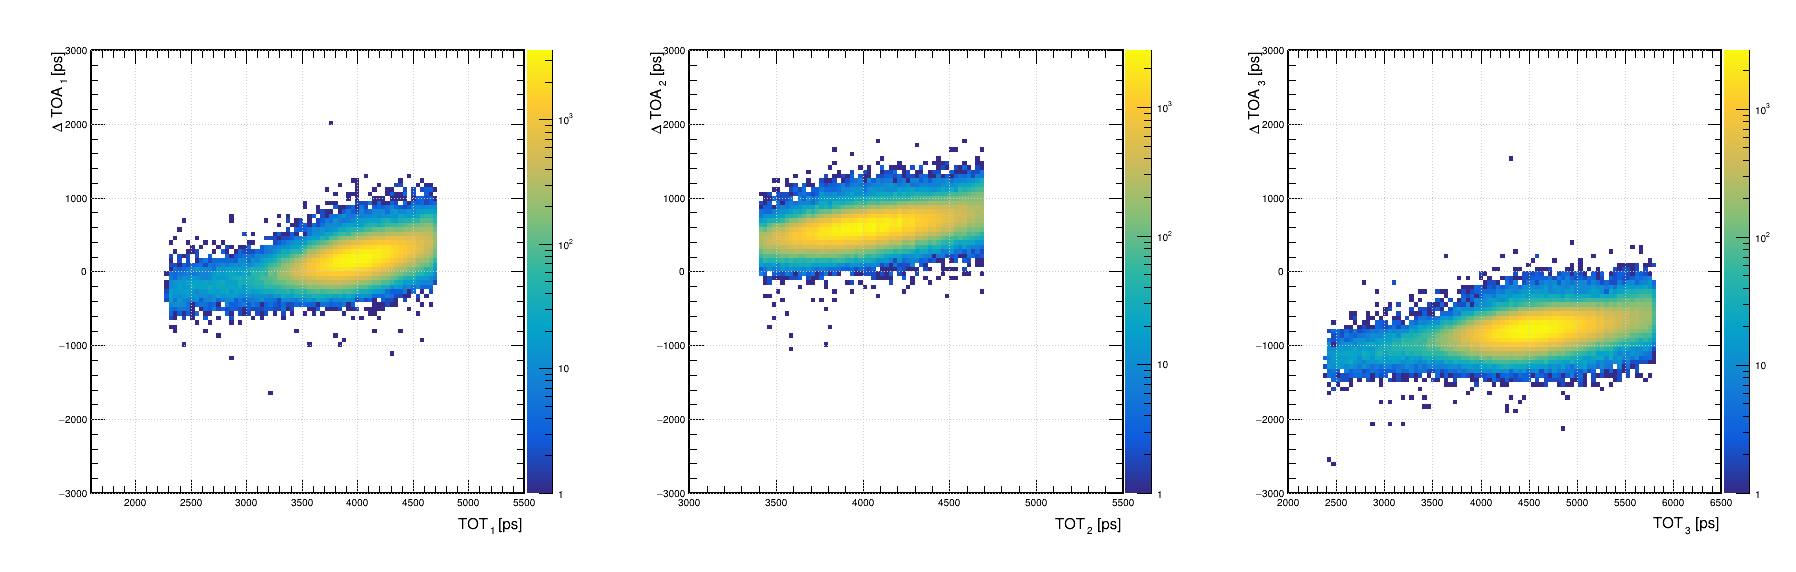

In [32]:
c1 = R.TCanvas("c1", "#Delta TOA", 1800, 600)  # Width = 1200, Height = 400
c1.Divide(3, 1)

h1 = R.TH2F("h1",";TOT_{1} [ps];#Delta TOA_{1} [ps]",100,1600,5500.,100,-3000,3000)
h2 = R.TH2F("h2",";TOT_{2} [ps];#Delta TOA_{2} [ps]",100,3000,5500.,100,-3000,3000)
h3 = R.TH2F("h3",";TOT_{3} [ps];#Delta TOA_{3} [ps]",100,2000,6500.,100,-3000,3000)
h = [h1,h2,h3]
for j in range(3):
    for i in tqdm(range(len(tot_uppercut[j]))):
        h[j].Fill(tot_uppercut[j][i],deltaTOA_uppercut[j][i])
c1.GetPad(1).SetLogz()
c1.GetPad(2).SetLogz()
c1.GetPad(3).SetLogz()
c1.cd(1)
h1.Draw("COLZ")
c1.cd(2)
h2.Draw("COLZ")
c1.cd(3)
h3.Draw("COLZ")
c1.Draw()

## Do a second iteration over TWC

In [40]:
corrtoa = [corrtoa1,corrtoa2,corrtoa3]
toa = [toa1,toa2,toa3]
tot = [tot1,tot2,tot3]

print('- Computing deltaTOA...')
deltaTOA = []
for i in range(3):
    j = (i+1) % 3
    k = (i+2) % 3
    print(i,j,k)
    toaj = corrtoa[j]
    toak = corrtoa[k]
    deltaTOA.append((toaj+toak)/2-toa[i])

- Computing deltaTOA...
0 1 2
1 2 0
2 0 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 389941/389941 [00:00<00:00, 1718558.07it/s]
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Warning in <TROOT::Append>: Replacing existing TH1: h1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h2 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h3 (Potential memory leak).


****************************************
Minimizer is Linear / Migrad
Chi2                      =      991.013
NDf                       =           17
p0                        =     -562.879   +/-   47.9198     
p1                        =    0.0238672   +/-   0.0281201   
p2                        =  3.55403e-05   +/-   4.00166e-06 
****************************************
Minimizer is Linear / Migrad
Chi2                      =      681.994
NDf                       =           17
p0                        =      -390.22   +/-   184.634     
p1                        =    0.0671947   +/-   0.0917234   
p2                        =   3.0298e-05   +/-   1.13143e-05 
****************************************
Minimizer is Linear / Migrad
Chi2                      =      1733.21
NDf                       =           17
p0                        =     -1373.65   +/-   42.9052     
p1                        =      0.23335   +/-   0.0217447   
p2                        = -8.81331e-06   +/-  

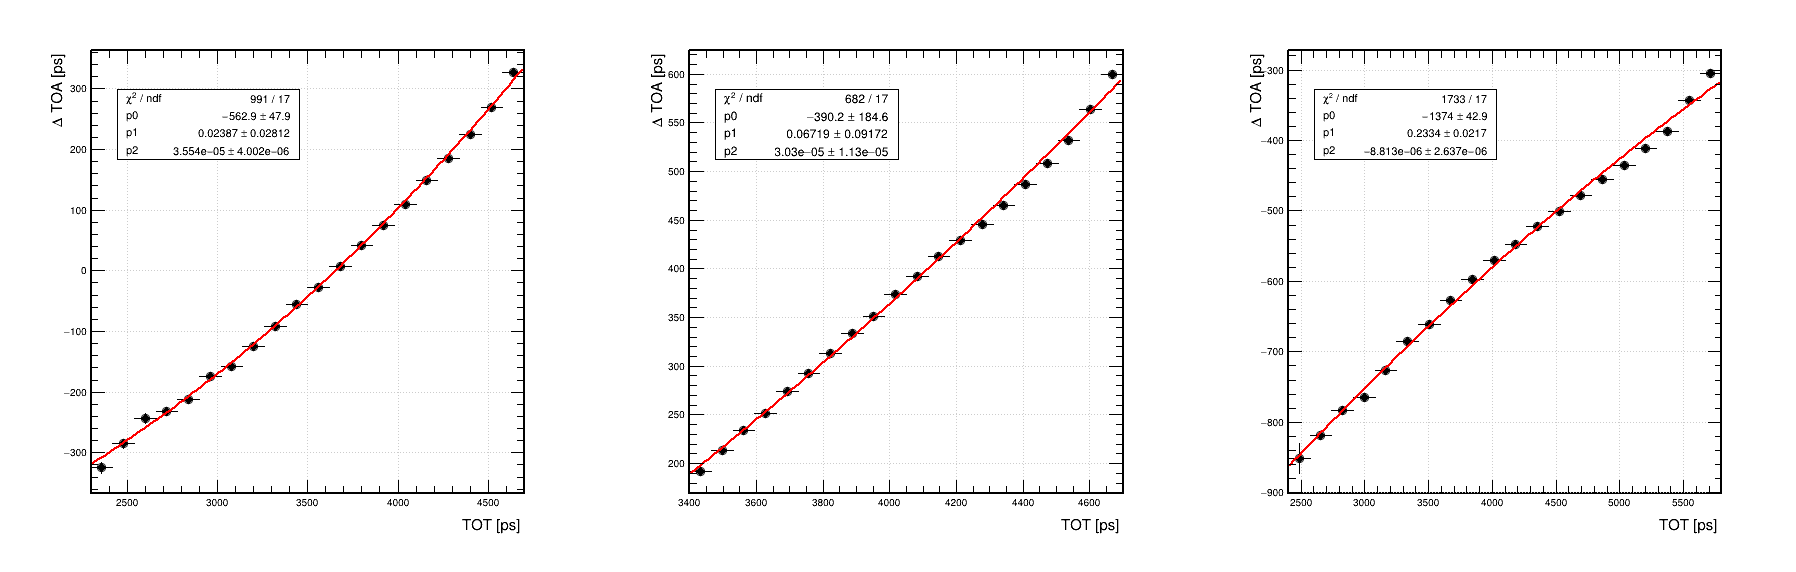

In [41]:
R.gStyle.SetStatX(0.5)
R.gStyle.SetStatY(0.85)
c1 = R.TCanvas("c1", "", 1800, 600)  # Width = 1200, Height = 400
c1.Divide(3, 1)

f1 = R.TF1("f1","pol2",0.,8000.)
f2 = R.TF1("f2","pol2",0.,8000.)
f3 = R.TF1("f3","pol2",0.,8000.)
h1 = R.TProfile("h1",";TOT [ps];#Delta TOA [ps]",20,2300.,4700.)
h2 = R.TProfile("h2",";TOT [ps];#Delta TOA [ps]",20,3400.,4700.)
h3 = R.TProfile("h3",";TOT [ps];#Delta TOA [ps]",20,2400.,5800.)
h = [h1,h2,h3]
for j in range(3):
    for i in tqdm(range(len(tot[j]))):
        h[j].Fill(tot[j][i],deltaTOA[j][i])
c1.cd(1)
h1.Draw("COLZ")
h1.Fit("f1","W","",2300.,4700.)
c1.cd(2)
h2.Draw("COLZ")
h2.Fit("f2","W","",3400.,4700.)
c1.cd(3)
h3.Draw("COLZ")
h3.Fit("f3","W","",2400.,5800.)
c1.Draw()

124.77572126269308 122.82188070116788 133.68980418029034
sigma1 = 95.80378379640788
sigma2 = 79.94132615184971
sigma3 = 93.24483230750918
****************************************
Minimizer is Minuit2 / Migrad
Chi2                      =   5.9321e+06
NDf                       =           97
Edm                       =  2.50496e-08
NCalls                    =           62
Constant                  =      17868.8   +/-   79.2928     
Mean                      =      18.7601   +/-   0.630043    
Sigma                     =      124.776   +/-   0.657847     	 (limited)
****************************************
Minimizer is Minuit2 / Migrad
Chi2                      =  2.22037e+06
NDf                       =           95
Edm                       =  1.91165e-06
NCalls                    =           56
Constant                  =      16495.6   +/-   45.7243     
Mean                      =     -59.1829   +/-   0.396741    
Sigma                     =      122.822   +/-   0.391947     	 (limit

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Warning in <TROOT::Append>: Replacing existing TH1: h1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h2 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h3 (Potential memory leak).


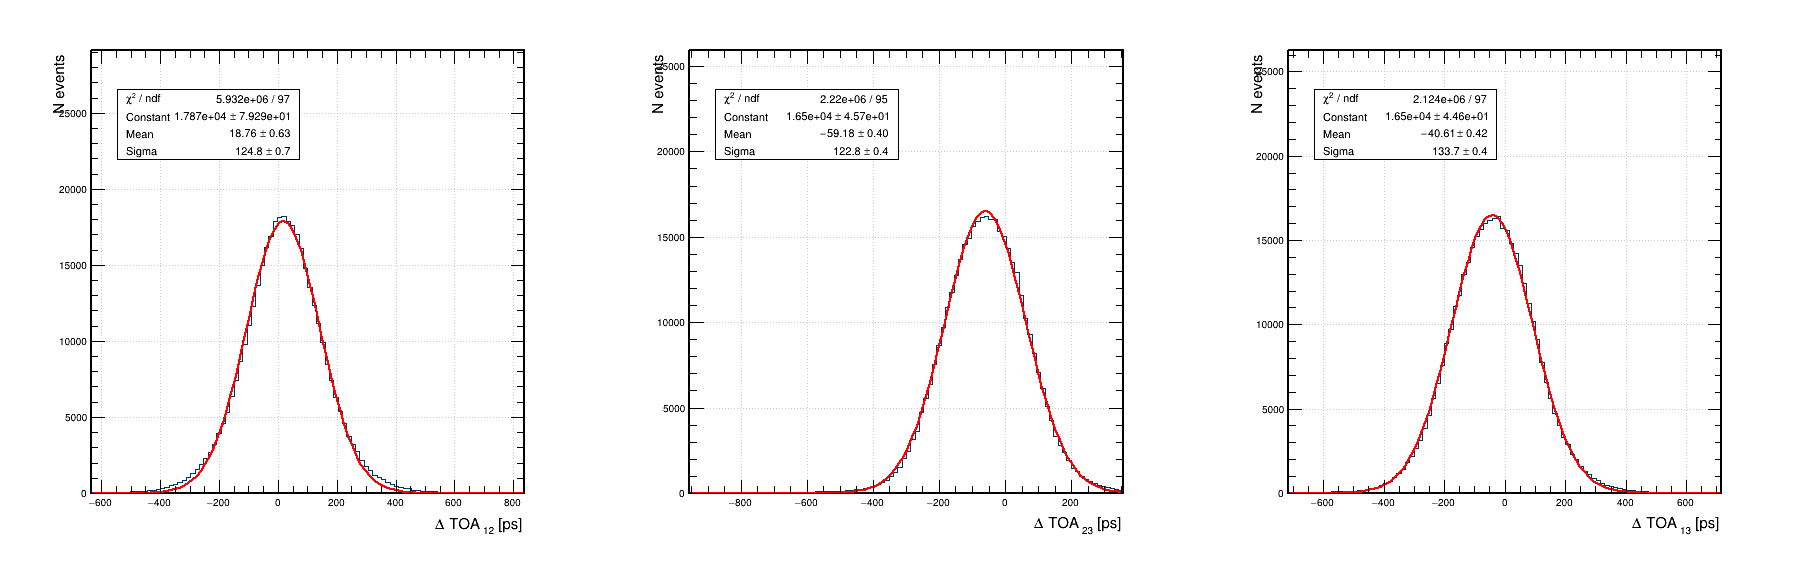

In [42]:
f1pars = [f1.GetParameter(0),f1.GetParameter(1),f1.GetParameter(2)]
f2pars = [f2.GetParameter(0),f2.GetParameter(1),f2.GetParameter(2)]
f3pars = [f3.GetParameter(0),f3.GetParameter(1),f3.GetParameter(2)]
ftot1 = f1pars[0] + f1pars[1]*tot1 + f1pars[2]*tot1*tot1
ftot2 = f2pars[0] + f2pars[1]*tot2 + f2pars[2]*tot2*tot2
ftot3 = f3pars[0] + f3pars[1]*tot3 + f3pars[2]*tot3*tot3
corrtoa1 = toa1 + ftot1
corrtoa2 = toa2 + ftot2
corrtoa3 = toa3 + ftot3

c1 = R.TCanvas("c1", "'#Delta TOA", 1800, 600)  # Width = 1200, Height = 400
c1.Divide(3, 1)

appr_mean = np.array([100, -300, 0])
appr_sigma = np.array([184, 164, 179])
lowlim = appr_mean-4*appr_sigma
highlim = appr_mean+4*appr_sigma

l = R.TLatex()
l.SetTextSize(0.03)
l.SetTextAlign(12)
l.SetTextFont(42)

hists = []

h1 = R.TH1F("h1",";#Delta TOA_{12} [ps]; N events",100,lowlim[0],highlim[0])
h1.FillN(len(toa2-toa1), corrtoa1-corrtoa2, np.ones(len(toa1)))
hists.append(h1)

h2 = R.TH1F("h2",";#Delta TOA_{23} [ps]; N events",100,lowlim[1],highlim[1])
h2.FillN(len(toa3-toa2), corrtoa2-corrtoa3, np.ones(len(toa2)))
hists.append(h1)

h3 = R.TH1F("h3",";#Delta TOA_{13} [ps]; N events",100,lowlim[2],highlim[2])
h3.FillN(len(toa1-toa3), corrtoa1-corrtoa3, np.ones(len(toa3)))
hists.append(h1)

c1.cd(1)
h1.Fit("fg1","W","",lowlim[0],highlim[0])
h1.SetMaximum(h1.GetMaximum()*1.6)
h1.SetLineColor(colorp[3])
h1.Draw()
#l.DrawLatexNDC(0.17,0.8,f"#mu = {fg1.GetParameter(1):.1f}#pm {fg1.GetParError(1):.1f} ps")
#l.DrawLatexNDC(0.17,0.77,f"#sigma = {fg1.GetParameter(2):.1f}#pm {fg1.GetParError(2):.1f} ps")

c1.cd(2)
h2.Fit("fg2","W","",lowlim[1],highlim[1])
h2.SetMaximum(h2.GetMaximum()*1.6)
h2.SetLineColor(colorp[3])
h2.Draw()
#l.DrawLatexNDC(0.17,0.8,f"#mu = {fg2.GetParameter(1):.1f}#pm {fg2.GetParError(1):.1f} ps")
#l.DrawLatexNDC(0.17,0.77,f"#sigma = {fg2.GetParameter(2):.1f}#pm {fg2.GetParError(2):.1f} ps")

c1.cd(3)
h3.Fit("fg3","W","",lowlim[2],highlim[2])
h3.SetMaximum(h3.GetMaximum()*1.6)
h3.SetLineColor(colorp[3])
h3.Draw()
#l.DrawLatexNDC(0.17,0.8,f"#mu = {fg3.GetParameter(1):.1f}#pm {fg3.GetParError(1):.1f} ps")
#l.DrawLatexNDC(0.17,0.77,f"#sigma = {fg3.GetParameter(2):.1f}#pm {fg3.GetParError(2):.1f} ps")

c1.Draw()

sigma12 = fg1.GetParameter(2)
sigma23 = fg2.GetParameter(2)
sigma13 = fg3.GetParameter(2)
print(sigma12, sigma23, sigma13)
sigma1 = np.sqrt((sigma12**2+sigma13**2-sigma23**2)/2)
sigma2 = np.sqrt((sigma12**2+sigma23**2-sigma13**2)/2)
sigma3 = np.sqrt((sigma23**2+sigma13**2-sigma12**2)/2)
print(f"sigma1 = {sigma1}")
print(f"sigma2 = {sigma2}")
print(f"sigma3 = {sigma3}")